# 03_genre_classification_demo.ipynb

Demo: Predict track genre from audio features using a Random Forest classifier.


In [1]:
# ─── cell 1: bootstrap the repo so `import src…` works ──────────────────────
import sys
from pathlib import Path

# assume this notebook lives in <project_root>/notebooks/
project_root = Path.cwd().parent   # up one from notebooks/
sys.path.insert(0, str(project_root))

print("📁 project root is:", project_root)
print("✅ src on PYTHONPATH? →", (project_root / "src").exists())

# now you can import your utils
from src.preprocessing.utils import get_project_root


📁 project root is: c:\Users\choks\OneDrive\Desktop\spotify-wrapped-analysis
✅ src on PYTHONPATH? → True


In [2]:
# Cell 1 — Setup imports & paths
import sys
from pathlib import Path

# Ensure `src/` is on the path
repo_root = Path.cwd()
sys.path.append(str(repo_root / "src"))

import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# For locating files
from src.preprocessing.utils import get_project_root

# Silence warnings
import warnings
warnings.filterwarnings("ignore")


## 1. Load & Inspect Data


In [3]:
# Cell 2 — Load the raw genre dataset
from pathlib import Path
import sys
import pandas as pd

# ─── Bootstrap src/ onto PYTHONPATH ─────────────────────────────────────────
# (Assumes this notebook lives in <repo_root>/notebooks/)
repo_root = Path().resolve().parent
sys.path.insert(0, str(repo_root))

# ─── Now you can import get_project_root ────────────────────────────────────
from src.preprocessing.utils import get_project_root

# ─── Locate & read the CSV ──────────────────────────────────────────────────
root = get_project_root()
data_path = root / "data" / "raw" / "genres_v2" / "genres_v2.csv"
df = pd.read_csv(data_path)

# ─── Quick checks ───────────────────────────────────────────────────────────
print(f"Total tracks: {len(df)}")
print(f"Unique genres: {df['genre'].nunique()}")

# Show top 10 genres by count
df["genre"].value_counts().head(10)


Total tracks: 42305
Unique genres: 15


genre
Underground Rap    5875
Dark Trap          4578
Hiphop             3028
trance             2999
trap               2987
techhouse          2975
dnb                2966
psytrance          2961
techno             2956
hardstyle          2936
Name: count, dtype: int64

## 2. Select Top 10 Genres for Demo


Filtered to top 10 genres: 34261 tracks


<Axes: title={'center': 'Top 10 Genres Count'}, xlabel='genre'>

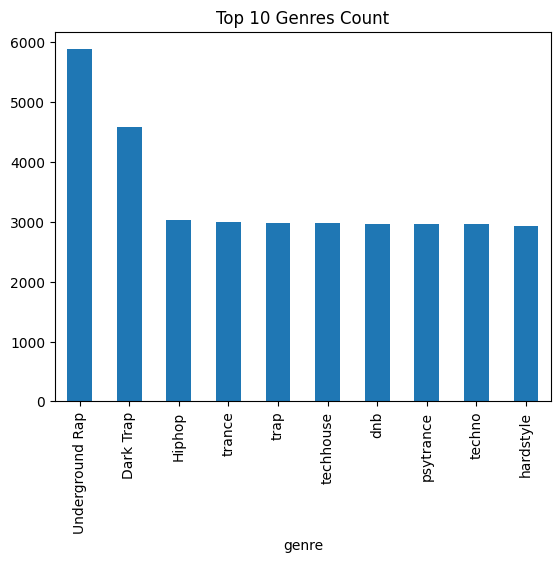

In [4]:
# Cell 3 — Pick the 10 most frequent genres
top_genres = df["genre"].value_counts().nlargest(10).index.tolist()
df_top = df[df["genre"].isin(top_genres)].copy()
print("Filtered to top 10 genres:", len(df_top), "tracks")
df_top["genre"].value_counts().plot.bar(title="Top 10 Genres Count")


## 3. Prepare Features & Labels


In [5]:
# Cell 4 — Define feature columns & extract X, y
feature_cols = [
    "danceability","energy","loudness","speechiness",
    "acousticness","instrumentalness","liveness",
    "valence","tempo"
]
X = df_top[feature_cols].astype(float)
y = df_top["genre"].astype(str)

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)
print("Classes:", le.classes_)


Classes: ['Dark Trap' 'Hiphop' 'Underground Rap' 'dnb' 'hardstyle' 'psytrance'
 'techhouse' 'techno' 'trance' 'trap']


## 4. Train/Test Split


In [6]:
# Cell 5 — Split into train & test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (27408, 9) Test: (6853, 9)


## 5. Train a Random Forest Classifier


In [7]:
# Cell 6 — Fit RandomForest
clf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)
print("Model trained.")


Model trained.


## 6. Evaluate Model


In [8]:
# Cell 7 — Predictions & classification report
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))


                 precision    recall  f1-score   support

      Dark Trap       0.55      0.47      0.51       916
         Hiphop       0.50      0.36      0.42       606
Underground Rap       0.53      0.64      0.58      1175
            dnb       0.98      0.99      0.98       593
      hardstyle       0.88      0.93      0.90       587
      psytrance       0.88      0.89      0.88       592
      techhouse       0.89      0.90      0.89       595
         techno       0.85      0.84      0.84       591
         trance       0.85      0.89      0.87       600
           trap       0.86      0.82      0.84       598

       accuracy                           0.75      6853
      macro avg       0.78      0.77      0.77      6853
   weighted avg       0.74      0.75      0.74      6853



## 7. Confusion Matrix


In [9]:
# Cell 8 — Compute & plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
fig_cm = px.imshow(
    cm,
    x=le.classes_,
    y=le.classes_,
    color_continuous_scale="Blues",
    labels={"x":"Predicted", "y":"Actual"},
    title="Confusion Matrix"
)
fig_cm.update_layout(width=700, height=600)
fig_cm.show()


## 8. Feature Importances


In [10]:
# Cell 9 — Extract and plot feature importances
importances = clf.feature_importances_
feat_imp = pd.DataFrame({
    "feature": feature_cols,
    "importance": importances
}).sort_values("importance", ascending=False)

fig_imp = px.bar(
    feat_imp,
    x="feature",
    y="importance",
    title="Feature Importances (Random Forest)",
    text="importance"
)
fig_imp.update_layout(xaxis_tickangle=-45)
fig_imp.show()


---
**Conclusion:**  
This demo shows that audio‐feature patterns (e.g. danceability, energy) can predict the top 10 genres with reasonable accuracy. You can extend this by tuning hyperparameters, adding more features, or using more sophisticated models.
